## To cluster a protein conformations using distance-matrix PCA

In this tutorial, conformational clustering of a flexible protein TFAM will be performed using the distance-matrix PCA (dmPCA). TFAM is a mitochondiral protein that interact and binds with the mitochondiral DNA. When TFAM is **bound** to the DNA, its conformation is **rigid**, however, in **unbound** form TFAM is **extremely flexible**.

### Final result
<img src="https://raw.githubusercontent.com/rjdkmr/gmx_clusterByFeatures/master/docs/images/distmat-pca-TFAM.png" width="1000"/>


### Instructions
* **Tutorial files**: The tutorial files can be downloaded from [here](https://figshare.com/ndownloader/files/55494644).
* **Extract the files**: `tar -zxvf distmat-TFAM-pca.tar.gz`
* **Go to directory**: `cd distmat-TFAM-pca`
* **Copy the Jupyter Notebook**: This notebook is available in the GitHub repo. [Download and copy it from the github](https://github.com/rjdkmr/gmx_clusterByFeatures/tree/master/docs/tutorials).

### Required Tools
* GROMACS
* gmx_clusterByFeatures

### Steps
Since the conformations are flexible, the fitting or superimposition is not accurate with the reference structure, therefore cartesian-coordinate PCA is not enough to accurately cluster the conformation. Instead we will employ distance-matrix based PCA to cluster the conformations of the TFAM. Following steps will be performed to do clustering:

 1. Calculation of distance-matrix over the trajectory
 2. PCA from the distance-matrix
 3. Calculation of Projections of first ten PCs on the trajectory
 4. Clustering using first ten PCs as the features
 5. Analysis


### 1. Calculation of distance-matrix over the trajectory

We will use `distmat` sub-command to calculate the distance-matrix over the trajectory. Following command will generate two files:

* `pca.xtc`: This file is a `container` for distance-matrices over the entire trajectory in `xtc` file format. This is **not a real trajectory** file.

* `pca_dummy.pdb`: This is a dummy pdb file containing same number of entries as obtained in above xtc file.

**Notes**
* `-gx 5` is used to reduce the size of distance-matrix. It means that there is a gap of 4 residues along X-axis in distance-matrix. For example, if a protein contains 100 residues, distance-matrix size is 100x100. If -gx 5 is used, new size is 20x100.
* `-gx` and `-gy` options **ONLY** affect output produced with `-pca` option of `distmat`.
* The distance-matrix **calculation is parallelized** using pthread, and therefore will use all the available threads of the CPU. It can be controlled using `-nt` option.

In [1]:
%%bash

echo 3 3 | gmx_clusterByFeatures distmat -f inputs/woDNA.xtc -s inputs/woDNA.tpr -n inputs/index.ndx -pca -gx 5 -std stdev-matrix.dat

 :-) GROMACS - gmx_clusterByFeatures distmat, 2025.0-dev-20250210-6949615-local (-:

Executable:   gmx_clusterByFeatures distmat
Data prefix:  /project/external/gmx_installed
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/distmat-TFAM-pca
Command line:
  'gmx_clusterByFeatures distmat' -f inputs/woDNA.xtc -s inputs/woDNA.tpr -n inputs/index.ndx -pca -gx 5 -std stdev-matrix.dat


         :-)  gmx_clusterByFeatures distmat (-:

             Author: Rajendra Kumar

       Copyright (C) 2018-2019  Rajendra Kumar


gmx_clusterByFeatures is a free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

gmx_clusterByFeatures is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Pu

Selected 3: 'C-alpha'
Selected 3: 'C-alpha'
 Number of distance-matrix elements for PCA trajectory: 3706
 Number of distance-matrix coordinates in PCA trajectory: 1236


### 2. PCA from the distance-matrix

Now, we will use `pca.xtc` and `pca_dummy.pdb` generated in the above command as input files to GROMACS tool `gmx covar` to perform PCA. This step will calculate covariance matrix, eigenvectors and eigenvalues. By default, the eigenvectors are written in `eigenvec.trr` while eigenvalues are written in `eigenval.xvg` files.

`-nofit`, `-nomwa` and `-nopbc` options are used because `xtc` file does not contain cartesian-coordinates and these option has no meanings in the case of the distance-matrix trajectory.

In [2]:
%%bash

echo 0 | gmx covar -f pca.xtc -s pca_dummy.pdb -nofit -nomwa -nopbc

                      :-) GROMACS - gmx covar, 2025.2 (-:

Executable:   /opt/gromacs-2025/bin/gmx
Data prefix:  /opt/gromacs-2025
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/distmat-TFAM-pca
Command line:
  gmx covar -f pca.xtc -s pca_dummy.pdb -nofit -nomwa -nopbc

Group     0 (         System) has  1236 elements
Group     1 (        Protein) has  1236 elements
Group     2 (      Protein-H) has  1236 elements
Group     3 (        C-alpha) has  1236 elements
Group     4 (       Backbone) has  1236 elements
Group     5 (      MainChain) has  1236 elements
Group     6 (   MainChain+Cb) has  1236 elements
Group     7 (    MainChain+H) has  1236 elements
Group     8 (      SideChain) has     0 elements
Group     9 (    SideChain-H) has     0 elements
Select a group: Calculating the average structure ...
Reading frame   32000 time 640000.000   
Constructing covariance matrix (3708x3708) ...
Reading frame   32000 time 640000.000   
Read 32016 frames

Trace of the covar


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.


Choose a group for the covariance analysis
Selected 0: 'System'


### 3. Projections of first ten PCs on the trajectory

We will use eigenvectors written in `eigenvec.trr`, `pca.xtc` and `pca_dummy.pdb` as input files to GROMACS tool `gmx anaeig` to calculate projection of first 10 eigenvectors on distance-matrix trajectory. These projections will be written into `proj.xvg` file.

In [3]:
%%bash

echo 0 0 | gmx anaeig -f pca.xtc -s pca_dummy.pdb -first 1 -last 10 -proj

                      :-) GROMACS - gmx anaeig, 2025.2 (-:

Executable:   /opt/gromacs-2025/bin/gmx
Data prefix:  /opt/gromacs-2025
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/distmat-TFAM-pca
Command line:
  gmx anaeig -f pca.xtc -s pca_dummy.pdb -first 1 -last 10 -proj

trr version: GMX_trn_file (single precision)
Eigenvectors in eigenvec.trr were determined without fitting
Read non mass weighted average/minimum structure with 1236 atoms from eigenvec.trr
Read 3708 eigenvectors (for 1236 atoms)


         that are broken across periodic boundaries, they
         cannot be made whole (or treated as whole) without
         you providing a run input file.

Group     0 (         System) has  1236 elements
Group     1 (        Protein) has  1236 elements
Group     2 (      Protein-H) has  1236 elements
Group     3 (        C-alpha) has  1236 elements
Group     4 (       Backbone) has  1236 elements
Group     5 (      MainChain) has  1236 elements
Group     6 (   Main


Select an index group of 1236 elements that corresponds to the eigenvectors
Selected 0: 'System'



### 4. Clustering using first ten PCs

Now, we will perform clustering using [K-Means algorithm](https://en.wikipedia.org/wiki/K-means_clustering). One of the **drawback** of K-Means clustering is that the number of clusters should be known beforehand. To automate the decision about number of clusters, `gmx_clusterByFeatures` implements several [cluster metrics](https://gmx-clusterbyfeatures.readthedocs.io/en/latest/commands/cluster.html#cmetric-prior). We will use option `-cmetric ssr-sst` to use the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering).

Following command will perform the clustering of conformations using firt 10 PCs projection. Explanation of options are as follows:
* `-method kmeans`: Use K-Means clustering algorithm
* `-ncluster 10`: K-Means clustering will be performed for 1 upto 10 clusters times each time. Finally, based on `-ssrchange` option, final number of clusters will be automatically selected.
* `-cmetric ssr-sst`: Use Elbow method to decide final number of clusters.
* `-nfeature 10`: Take 10 feature from `feat proj.xvg` input file. Here it is projection of first ten eigenvectors.
* `-sort features`: Sort the output clustered trajectory based on the distance in feature space from its central structure.
* `-fit2central`: Fit/Superimpose the conformation on central structure in output clustered trajectory.
* `-ssrchange 2`: Threshold (percentage) of change in SSR/SST ratio in Elbow method to decide the number of clusters.
* `-cpdb clustered-trajs/central.pdb`: Dump central conformation of each cluster as a separate pdb file.
* `-fout clustered-trajs/cluster.xtc`: Dump conformations of each cluster as the separate trajectory file.
* `-plot pca_cluster.png`: Plot the feature-space (here, it is first 10 PCs from PCA) coloured by the clusters.
* `-rmsd clustered-trajs/rmsd.xvg`: Calculate the RMSD with reference to central conformation of each clusters and written in separate files.

**index group order**

1. **First index** group - Output group of atoms in the central structures and clustered trajectories

2. **Second index** group - Group of atoms to calculate distance-matrix RMSD between central conformations of clusters as RMSD matrix, which is dumped in the **log file** with `-g` option. Here, it is C-alpha atoms of protein. 
    
3. **Third index** group - Used for Superimposition by least-square fitting. ONLY used in separate clustered trajectories to superimpose conformations on the central structure.


**Note: This command could take a long time to execute!**

This command could take a long time to execute because it is writing output trajectory file for each cluster sorted by distance in feature-space. Therefore, it needs **to read input trajectory back-and-forth** many time to extract the conformations in sorted manner. **XTC** format is fast for **back-and-forth** reading, and it still could take long time to dump the output trajectories.

**Content of output `-g cluster.log` file**

It contains the command summary, and for each input cluster-numbers, number of frames in each clusters. At the end, it contains the **Cluster Metrics Summary**, which is important for deciding final number of clusters.

In [ ]:
%%bash

# create a new folder to contain clustered trajectory and pdb files
mkdir clustered-trajs

echo 0 3 3 | gmx_clusterByFeatures cluster -s inputs/woDNA.tpr -f inputs/woDNA.xtc -n inputs/index.ndx -feat proj.xvg -method kmeans \
                                           -nfeature 10 -cmetric ssr-sst -ncluster 20 -fit2central -sort rmsdist \
                                           -ssrchange 2 -cpdb clustered-trajs/central.pdb -fout clustered-trajs/cluster.xtc \
                                           -plot pca_cluster.png

 :-) GROMACS - gmx_clusterByFeatures cluster, 2025.0-dev-20250210-6949615-local (-:

Executable:   gmx_clusterByFeatures cluster
Data prefix:  /project/external/gmx_installed
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/distmat-TFAM-pca
Command line:
  'gmx_clusterByFeatures cluster' -s inputs/woDNA.tpr -f inputs/woDNA.xtc -n inputs/index.ndx -feat proj.xvg -method kmeans -nfeature 10 -cmetric ssr-sst -ncluster 20 -fit2central -sort rmsdist -ssrchange 2 -cpdb clustered-trajs/central.pdb -fout clustered-trajs/cluster.xtc -plot pca_cluster.png


         :-)  gmx_clusterByFeatures cluster (-:

             Author: Rajendra Kumar

       Copyright (C) 2018-2019  Rajendra Kumar


gmx_clusterByFeatures is a free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

gmx_clusterByFeatures is distributed in th

  Cluster Log output   

Command:
'gmx_clusterByFeatures cluster' -s inputs/woDNA.tpr -f inputs/woDNA.xtc -n inputs/index.ndx -feat proj.xvg -method kmeans -nfeature 10 -cmetric ssr-sst -ncluster 20 -fit2central -sort rmsdist -ssrchange 2 -cpdb clustered-trajs/central.pdb -fout clustered-trajs/cluster.xtc -plot pca_cluster.png

Choose a group for the output:
Selected 0: 'System'

Choose a group for clustering/RMSD calculation:
Selected 3: 'C-alpha'

Choose a group for fitting or superposition:
Selected 3: 'C-alpha'


 Input Trajectory dt = 20 ps



###########################################
########## NUMBER OF CLUSTERS : 1 ########
###########################################

Cluster-ID	TotalFrames
1		32016



###########################################
########## NUMBER OF CLUSTERS : 2 ########
###########################################

Cluster-ID	TotalFrames
1		16361
2		15655



###########################################
########## NUMBER OF CLUSTERS : 3 ########
###############

Reading frame       7 time 274760.000   <string>:127: MatplotlibDeprecationWarning: The non_interactive_bk attribute was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use ``matplotlib.backends.backend_registry.list_builtin(matplotlib.backends.BackendFilter.NON_INTERACTIVE)`` instead.
Reading frame    2000 time 220340.000   

### 5. Analysis
Now, we will perform following analysis on obtained clusters:

1. **Comparison of Distance-Matrix-RMSDs within and between the clusters**: It will highlight the quality of clustering by measuring the difference in the clusters using distance-matrix RMSD
2. **Plotting PC vs PC cluster-wise**. In fact, this is already plotted in the above obtained `pca_cluster.png` file. However, we will focus on first three PCs to demonstrate the distribution of conformation in PC space.
3. **Plotting distance-matrix-RMSF**: Because, we are calculating distance-matrix over the trajectory, it gives us another way to compute RMSF by using distance-matrix. To gain insight of the flexible and rigid regions of the protein, this analysis is useful. It is similar to RMSF but **avoids structure fitting** and therefore, suitable for highly flexible proteins.
4. **Cluster-ID with time**: We will plot cluster-id as a function of time to analyze, how conformation is changing between clusters as a function of time.

At first, we will load Python modules and define some functions as follows:

In [13]:
import re
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [14]:
def read_mat_file(filename):
    ''' Read the matrix file generated from distmat sub-command
    '''
    fin = open(filename, 'r')

    data = []
    for line in fin:
        line = line.rstrip().lstrip()
        if not line:
            continue

        temp = re.split('\s+', line)
        data.append(list(map(float, temp)))

    data = np.asarray(data)

    return data.T

def read_xvg(filename):
    ''' Read any XVG file and return the data as 2D array where data is row-wise with respect to time.
    '''
    fin = open(filename, 'r')

    data = []
    for line in fin:
        line = line.rstrip().lstrip()
        if not line:
            continue

        if re.search('^#|^@', line) is not None:
                     continue

        temp = re.split('\s+', line)
        data.append(list(map(float, temp)))

    data = np.asarray(data)

    return data.T

#### 1a. Calculation of Distance-Matrix-RMSDs within and between the clusters

At first, we need to calculate distance-matrix RMSD within and between the clusters using `gmx rmsdist` command as follows.

**Note:** Remove `%%capture --no-stdout` and `%%capture --no-stderr` to populate all the output generated from `gmx rmsdist` commands. 

In [15]:
%%capture --no-stdout
%%capture --no-stderr
%%script bash

mkdir rmsdist

# Nested For loop to calculate rmsdist of clustered-trajectory with reference to central structure with all possible combinations.
for i in `seq 1 8`
do
    for j in `seq 1 8`
    do
        echo 3 | gmx rmsdist -f clustered-trajs/cluster_c${j}.xtc -s clustered-trajs/central_c${i}.pdb -o rmsdist/c${i}_c${j} -nopbc
    done
done

#### 1b. Comparison of Distance-Matrix-RMSDs within and between the clusters

We will use Python to plot all the obtained Distance-Matrix-RMSDs above. 

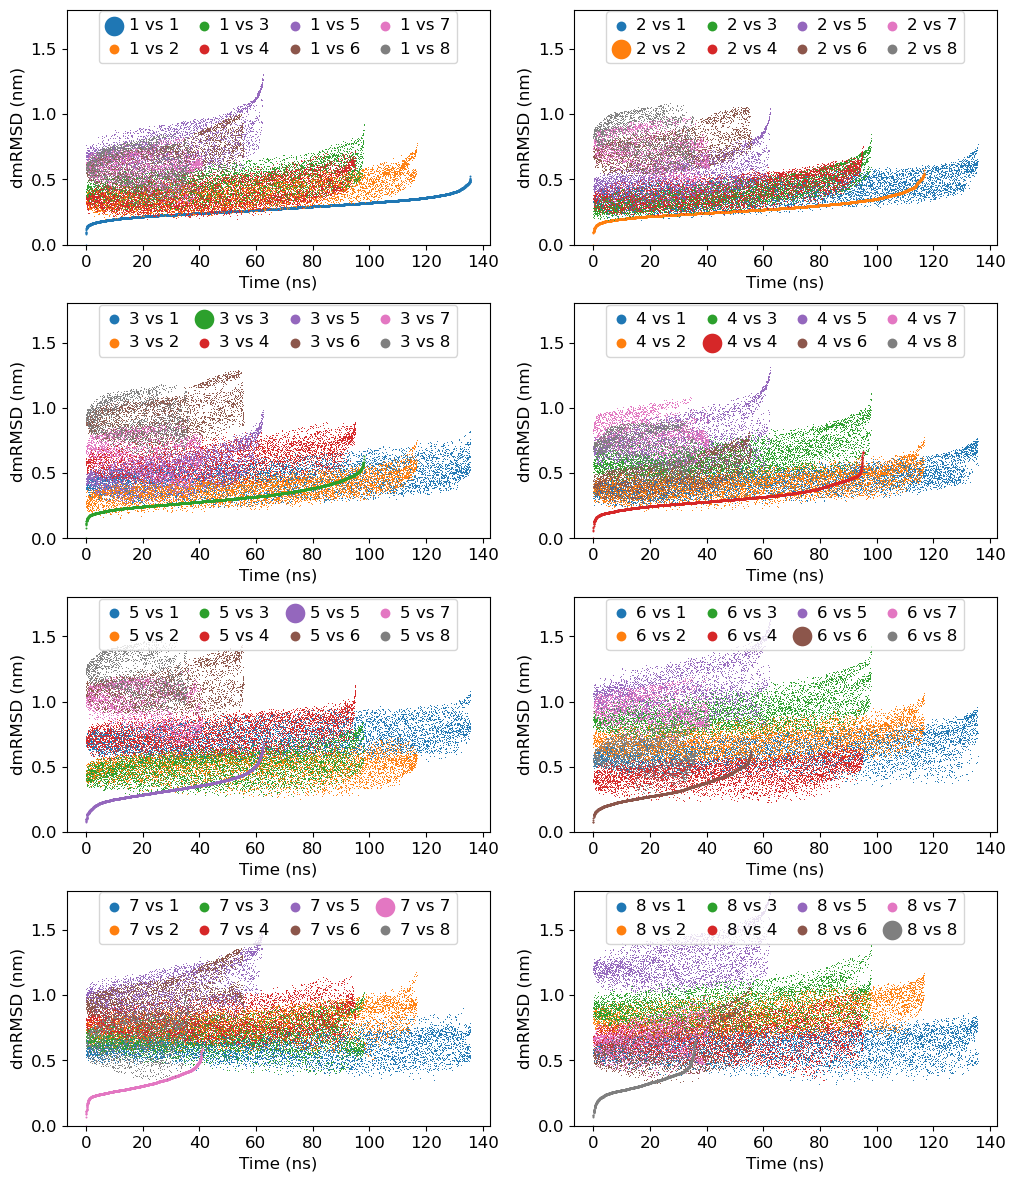

In [16]:
mpl.rcParams['font.size']=12
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(top=0.98, bottom=0.05, hspace=0.25)

for i in range(1,9):
    
    ax = fig.add_subplot(4, 2, i)
    
    for j in range(1,9):
        filename = 'rmsdist/c{0}_c{1}.xvg'.format(i, j)
        label = "{0} vs {1}".format(i, j)
        data = read_xvg(filename) # read file
        if i==j:
            ax.scatter(data[0]/1000, data[1], label=label, lw=0, s=2)
        else:
            ax.scatter(data[0]/1000, data[1], label=label, lw=0, s=0.5)
        
    ax.set_ylim(0, 1.8)
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('dmRMSD (nm)')
    plt.legend(loc='upper center', ncol=4, markerscale=10, borderaxespad=0.1, columnspacing=1, handlelength=1, handletextpad=0.4)
    

plt.savefig('rmsdist/rmsdist.png', dpi=300)
plt.show()

#### 2. Plotting PC vs PC cluster-wise

It will be done in two steps:

1. An input file will be prepared containing information about feature searial and their labels.
2. `gmx_clusterByFeatures featuresplot` will be used to generate the plot.

In [21]:
%%bash

# First step - preparation of input file
echo "1,2,PC-1,PC-2" > features-label.txt
echo "2,3,PC-2,PC-3" >> features-label.txt
echo "1,3,PC-1,PC-3" >> features-label.txt
echo "1,4,PC-1,PC-4" >> features-label.txt
cat features-label.txt

# Second step - plotting
gmx_clusterByFeatures featuresplot -i features-label.txt -feat proj.xvg -clid clid.xvg -o distmat-pca-TFAM-PCs-vs-PCs.png

1,2,PC-1,PC-2
2,3,PC-2,PC-3
1,3,PC-1,PC-3
1,4,PC-1,PC-4


<img src="distmat-pca-TFAM-PCs-vs-PCs.png" width="650"/>

#### 3a. Plotting distance-matrix-RMSF

Here we compare dmRMSF and conventional RMSF
1. We plot the standard deviation in distances in distance matrix. We use `stdev-matrix.dat` file obtained from `distmat` sub-command as the input file.
2. We calculate RMSF of the protein using `gmx rmsf`

In [18]:
%%bash

# Generate the dmRMSF plot 
gmx_clusterByFeatures matplot -i stdev-matrix.dat -o dmRMSF-matrix.png

# Calculate the conventional RMSF 
echo 3 | gmx rmsf -f inputs/woDNA.xtc -s inputs/woDNA.tpr -n inputs/index.ndx -res -o rmsf.xvg

                       :-) GROMACS - gmx rmsf, 2025.2 (-:

Executable:   /opt/gromacs-2025/bin/gmx
Data prefix:  /opt/gromacs-2025
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/distmat-TFAM-pca
Command line:
  gmx rmsf -f inputs/woDNA.xtc -s inputs/woDNA.tpr -n inputs/index.ndx -res -o rmsf.xvg

Reading file inputs/woDNA.tpr, VERSION 4.5.5-dev-20110921-e25c350 (single precision)
Reading file inputs/woDNA.tpr, VERSION 4.5.5-dev-20110921-e25c350 (single precision)
Select group(s) for root mean square calculation
Group     0 (         System) has  3580 elements
Group     1 (        Protein) has  3580 elements
Group     2 (      Protein-H) has  1884 elements
Group     3 (        C-alpha) has   195 elements
Group     4 (       Backbone) has   585 elements
Group     5 (      MainChain) has   781 elements
Group     6 (   MainChain+Cb) has   973 elements
Group     7 (    MainChain+H) has   969 elements
Group     8 (      SideChain) has  2611 elements
Group     9 (    SideCh

Selected 3: 'C-alpha'


<img src="dmRMSF-matrix.png" width="650"/>

#### 3b. Deriving residue-wise fluctuation from dmRMSF
Above standard-deviation is a matrix. Therefore, to calculate fluctuations of residues, we will calculate mean of each rows.
It will give the idea about fluctuations of each residue as simular to that of conventional RMSF. Subsequently, `rmsf.xvg` is 
read and plotted.

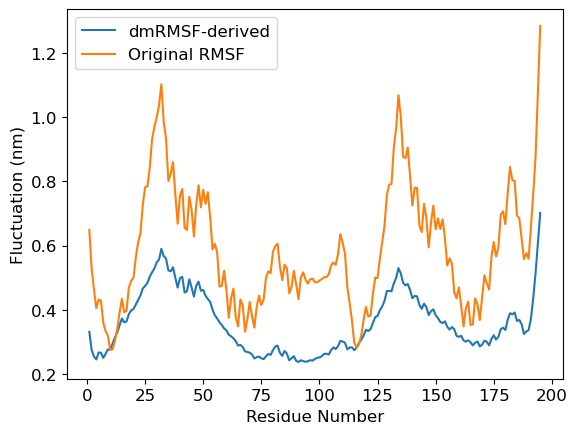

In [19]:
dmRMSF = read_mat_file('stdev-matrix.dat') # read the stdev-matrix.dat file containing standard-deviation of distance matrix
derived_dmRMSF = np.mean(dmRMSF, axis=1)   # Derive the fluctuation by averaging over rows
rmsfData = read_xvg('rmsf.xvg')            # Read the conventional RMSF data

mpl.rcParams['font.size']=12
plt.plot(rmsfData[0], derived_dmRMSF, label='dmRMSF-derived')
plt.plot(rmsfData[0], rmsfData[1], label='Original RMSF')
plt.xlabel('Residue Number')
plt.ylabel('Fluctuation (nm)')
plt.legend()
plt.show()

#### 4. Cluster-ID with time
We will use `clid.xvg` obtained from the `cluster` subcommand to plot both cluster-id and also highlight the occurance of the given cluster. 

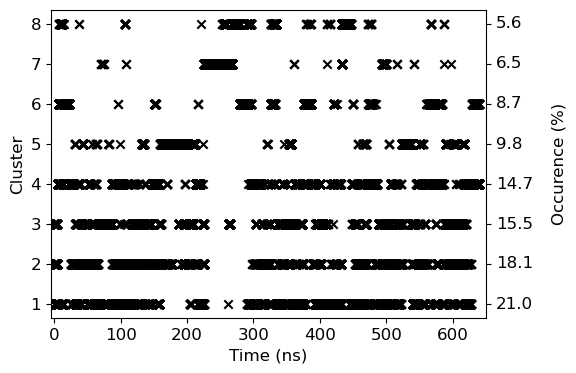

In [20]:
# Occurance has been calculated manually from the data obtained in cluster.log file
occur=[ 21.0, 18.1, 15.5, 14.7, 9.8, 8.7, 6.5, 5.6]

mpl.rcParams['font.size']=12

data=read_xvg('clid.xvg')
fig = plt.figure(figsize=(6,4))
fig.subplots_adjust(right=0.85)

ax = fig.add_subplot(111)
ax.scatter(data[0]/1000, data[1], marker='x', color='k')
ax.tick_params(axis='y', right=True)

ax.set_ylabel('Cluster')
ax.set_xlabel('Time (ns)')
ax.set_xlim(-5, 650)
for i in range(8):
    ax.text(665, i+1, '{0:3.1f}'.format(occur[i]), verticalalignment='center')
ax.text(760, 4.5, 'Occurence (%)', verticalalignment='center', rotation='vertical', horizontalalignment='center')

plt.savefig('clid.png', dpi=300)
plt.show()